In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from stats import *

from rdkit import Chem
from rdkit.Chem import PandasTools

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

RDKit ERROR: [16:32:24] Explicit valence for atom # 36 N, 5, is greater than permitted
RDKit ERROR: [16:32:24] ERROR: Could not sanitize molecule ending on line 660489


Original data:  (9614, 7)
Kept data:  (9614, 7)


,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,InChIKey,ID,SMILES,Mol
0,Elenbecestat,DB15391,investigational,AACUJFVOHGRMTR-DPXNYUHVSA-N,,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,

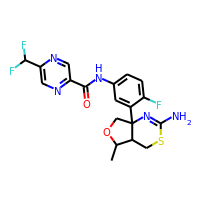

In [2]:
# Set file path
file = '../datasets/curated_data/drugbank.sdf.gz'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)

,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,InChIKey,SMILES,Mol,sirms,sirms_ad,sirms_conf,dragon,dragon_ad,dragon_conf,morgan,morgan_ad,morgan_confidence
0,Elenbecestat,DB15391,investigational,AACUJFVOHGRMTR-DPXNYUHVSA-N,CC1OCC2(c3cc(NC(=O)c4cnc(C(F)F)cn4)ccc3F)N=C(N...,,0.0,NaN,0.64,0,0.0,0.81,0.0,NaN,0.57
1,Eticlopride,DB15492,experimental,AADCDMQTJNYOSS-LBPRGKRZSA-N,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,,0.0,NaN,0.67,0,NaN,0.62,0.0,NaN,0.69
2,Pirnabine,DB12840,investigational,AADNQNOXNWEYHS-UHFFFAOYNA-N,CC(=O)Oc1cc(C)cc2c1C1=C(CCC(C)C1)C(C)(C)O2,,0.0,NaN,0.63,0,0.0,0.71,0.0,0.0,0.75
3,Dianhydrogalactitol,DB12873,investigational,AAFJXZWCNVJTMK-GUCUJZIJSA-N,OC(C1CO1)C(O)C1CO1,,0.0,NaN,0.67,1,NaN,0.50,0.0,0.0,0.80
4,"N-1,10-phenanthrolin-5-ylacetamide",DB08440,experimental,AAJXINSCZMZERD-UHFFFAOYSA-N,CC(=O)Nc1cc2cccnc2c2ncccc12,,0.0,0.0,0.70,0,NaN,0.66,0.0,0.0,0.71

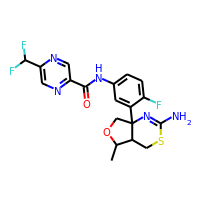
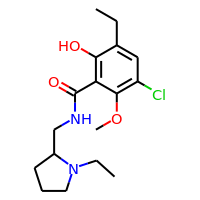
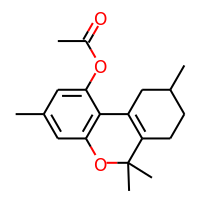
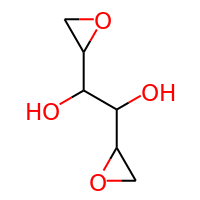
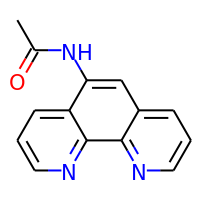

In [3]:
sirms_dragon = pd.read_excel('datasets/screened_compounds/drugbank_hits_qsar_sirms-morgan.xlsx')
sirms_dragon.drop(columns=['consensus', 'consensus_ad'], inplace=True)
morgan = pd.read_excel('datasets/screened_compounds/drugbank_hits_qsar_morgan.xlsx')
morgan.rename(columns={'Prediction': 'morgan', 'AD': 'morgan_ad', 'Confidence': 'morgan_confidence'}, inplace=True)

predictions = pd.merge(sirms_dragon, morgan[['InChIKey', 'morgan', 'morgan_ad', 'morgan_confidence']], how='inner', on='InChIKey')
for col in ['sirms', 'sirms_ad', 'dragon', 'dragon_ad', 'morgan', 'morgan_ad']:
    predictions[col].replace('Inactive',0,inplace=True)
    predictions[col].replace('Active',1,inplace=True)
predictions.head()

In [4]:
predictions = pd.merge(moldf[['InChIKey', 'SMILES']], predictions, how='inner', on='InChIKey')

In [6]:
# Consensus
predictions['consensus'] = (predictions.sirms + predictions.dragon + predictions.morgan)/3
predictions['consensus'] = np.where(predictions['consensus'] > 0.5, 1, np.where(predictions['consensus'] == 0.5, np.nan, 0))

In [7]:
# Consensus AD
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i] + predictions.morgan_ad[i])/3
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.dragon_ad[i] + predictions.morgan_ad[i])/2
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.morgan_ad[i])/2
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i])/2
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.sirms_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.dragon_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = predictions.morgan_ad[i]
    else:
        predictions.loc[i,'consensus_ad']  = np.nan

predictions['consensus_ad'] = np.where(predictions['consensus_ad'] > 0.5, 1, np.where(predictions['consensus_ad'] == 0.5, np.nan, 0))

,InChIKey,SMILES_x,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,SMILES_y,Mol,sirms,sirms_ad,sirms_conf,dragon,dragon_ad,dragon_conf,morgan,morgan_ad,morgan_confidence,consensus,consensus_ad
224,AOMZDQMIOCTPQP-QHQMVRJISA-N,CC(C)(C)NC(=O)C1CN(Cc2cc3ccccc3o2)CCN1CC(O)CC(...,L-756423,DB02009,experimental,CC(C)(C)NC(=O)C1CN(Cc2cc3ccccc3o2)CCN1CC(O)CC(...,,1.0,NaN,0.59,1,NaN,0.53,0.0,NaN,0.63,1.0,0.0
372,AXRYRYVKAWYZBR-GASGPIRDSA-N,COC(=O)NC(C(=O)NC(Cc1ccccc1)C(O)CN(Cc1ccc(-c2c...,Atazanavir,DB01072,approved; investigational,COC(=O)NC(C(=O)NC(Cc1ccccc1)C(O)CN(Cc1ccc(-c2c...,,1.0,NaN,0.56,1,NaN,0.60,0.0,NaN,0.61,1.0,0.0
430,BBRISSLDTUHWKG-SRPALZIWNA-O,CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc...,(R)-carnitinyl-CoA betaine,DB02516,experimental,CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc...,,1.0,NaN,0.52,0,NaN,0.68,1.0,NaN,0.56,1.0,0.0
582,BLFKRFGLQFYXDF-CXHHYSKISA-N,COc1ccc2nc3c(nc2c1)OC1CC2C(=O)NC4(C(=O)NS(=O)(...,MK-6325,DB15249,investigational,COc1ccc2nc3c(nc2c1)OC1CC2C(=O)NC4(C(=O)NS(=O)(...,,1.0,NaN,0.61,0,NaN,0.66,1.0,NaN,0.51,1.0,0.0
818,CABBMMXFOOZVMS-PMERELPUSA-N,CC(C)N(C(=O)CN1C(=O)C(NC(=O)Nc2cccc(C(=O)O)c2)...,GI-181771X,DB12309,investigational,CC(C)N(C(=O)CN1C(=O)C(NC(=O)Nc2cccc(C(=O)O)c2)...,,1.0,NaN,0.55,1,NaN,0.58,0.0,NaN,0.67,1.0,0.0
854,CBVCZFGXHXORBI-PXQQMZJSSA-N,CC(C)(C)NC(=O)C1CN(Cc2cccnc2)CCN1CC(O)CC(Cc1cc...,Indinavir,DB00224,approved,CC(C)(C)NC(=O)C1CN(Cc2cccnc2)CCN1CC(O)CC(Cc1cc...,,1.0,NaN,0.60,1,NaN,0.52,0.0,NaN,0.58,1.0,0.0
1034,COVPLULNDBDXTN-KYJUHHDHSA-N,CNC(=O)C(Cc1ccc2ccccc2c1)N1CCC(=O)N(Cc2cnc3ccc...,"(S)-2-((S)-3-isobutyl-2,5-dioxo-4-quinolin-3-y...",DB04724,experimental,CNC(=O)C(Cc1ccc2ccccc2c1)N1CCC(=O)N(Cc2cnc3ccc...,,1.0,NaN,0.57,1,NaN,0.57,0.0,NaN,0.62,1.0,0.0
1208,DBOGGOVKHSCMNB-OMRVPHBLSA-N,CCCCC(NC(=O)C(Cc1ccccc1)NC(=O)C(N)Cc1ccccc1)C(...,CR665,DB05155,investigational,CCCCC(NC(=O)C(Cc1ccccc1)NC(=O)C(N)Cc1ccccc1)C(...,,1.0,NaN,0.56,1,NaN,0.61,0.0,NaN,0.60,1.0,0.0
1241,DDOOHEYBNHOFCV-ORYMTKCHSA-N,CC(C)(C)OC(=O)NC(Cc1ccccc1)C(=O)CC(Cc1ccccc1)C...,"Tert-butyl N-[(2S,5R)-6-[[(2S)-5-amino-1-[[(2S...",DB04353,experimental,CC(C)(C)OC(=O)NC(Cc1ccccc1)C(=O)CC(Cc1ccccc1)C...,,1.0,NaN,0.52,1,NaN,0.59,0.0,0.0,0.70,1.0,0.0
1343,DKQZZKSBRCTCQU-QFIPXVFZSA-N,O=C(O)CCCC(=O)NC(Cc1ccccc1)P(=O)(O)OCC(=O)NCCc...,N-{[2-({[1-(4-CARBOXYBUTANOYL)AMINO]-2-PHENYLE...,DB07881,experimental,O=C(O)CCCC(=O)NC(Cc1ccccc1)P(=O)(O)OCC(=O)NCCc...,,1.0,NaN,0.56,1,NaN,0.55,0.0,NaN,0.69,1.0,0.0

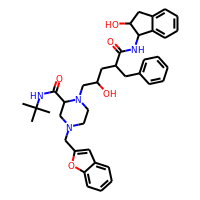
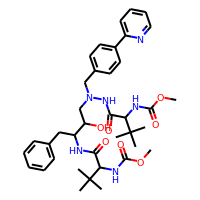
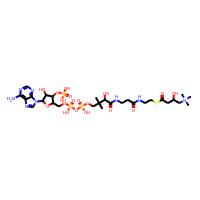
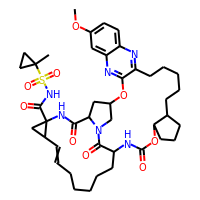
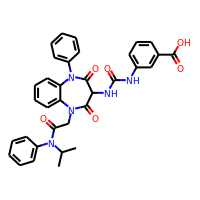
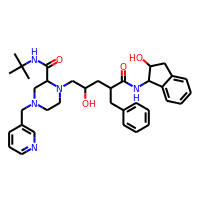
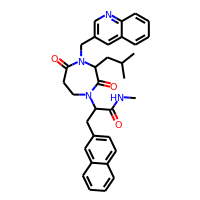
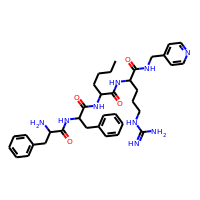
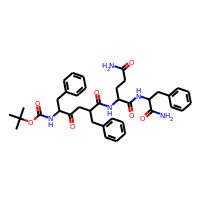
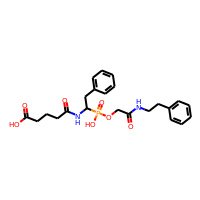
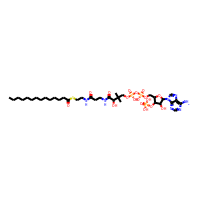
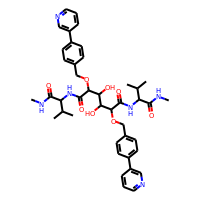
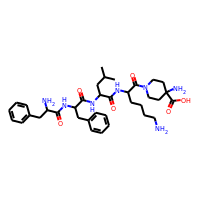
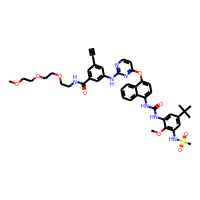
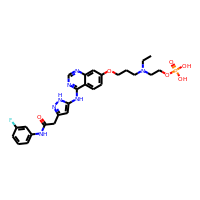
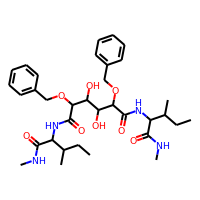
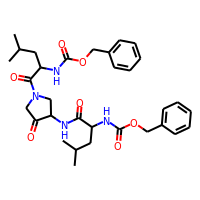
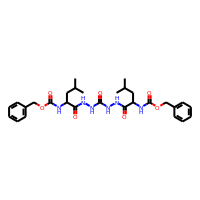
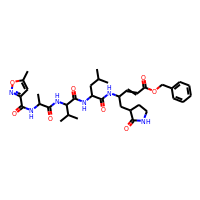
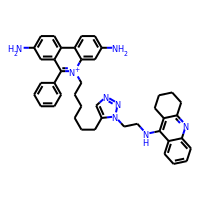
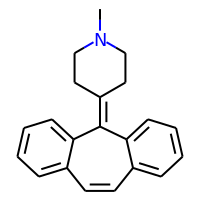
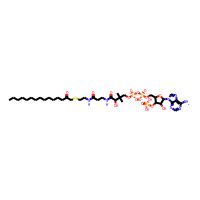
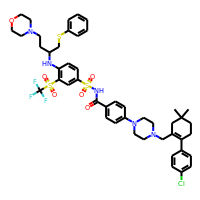
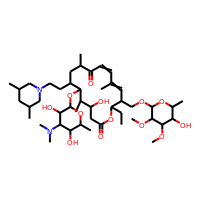
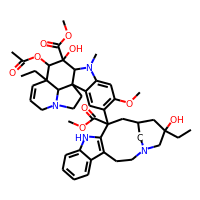
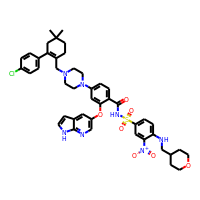
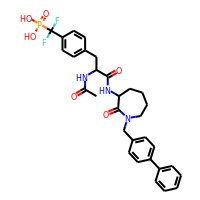
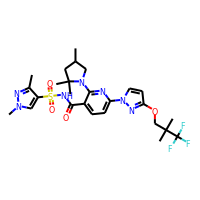
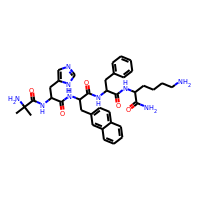
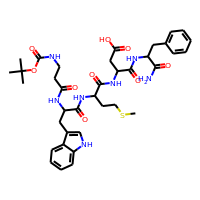
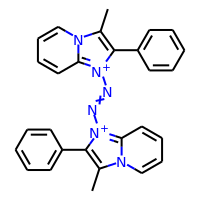
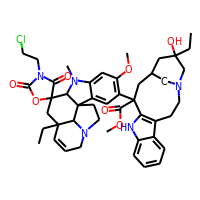
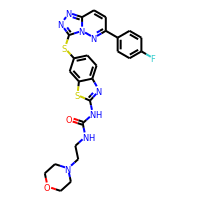
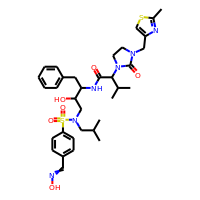
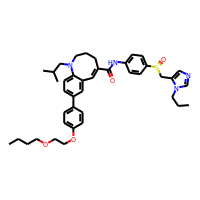
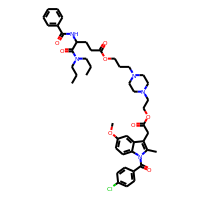
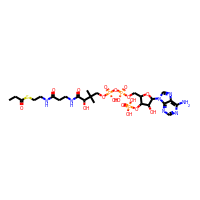
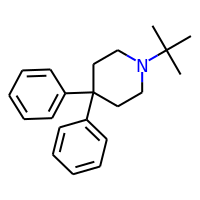
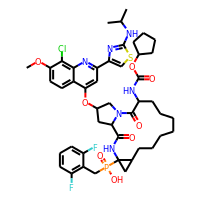
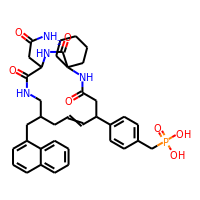
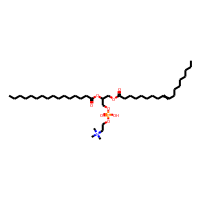
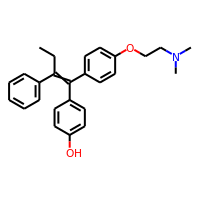
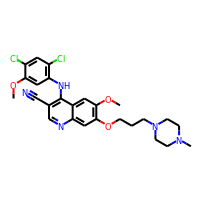
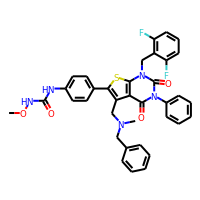
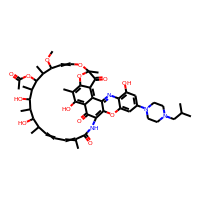
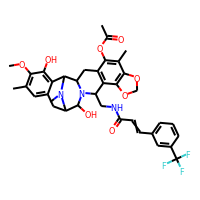
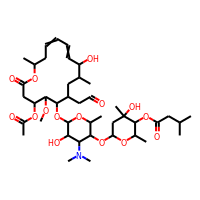
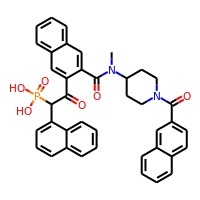
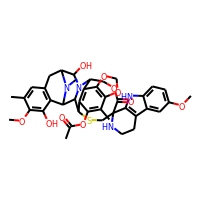
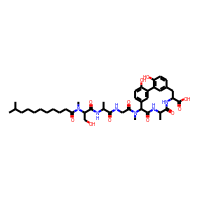
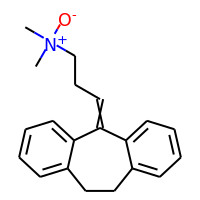
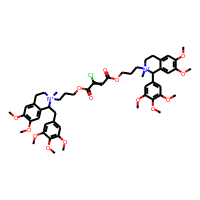

In [10]:
predictions[predictions['consensus'] == 1]

In [8]:
predictions.drop('Mol', axis=1)
with pd.ExcelWriter('datasets/screened_compounds/drugbank_hits_qsar_consensus.xlsx') as writer:
    predictions.to_excel(writer, sheet_name='consensus', index=False)